In [272]:
import torch
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

In [273]:
words = open('names.txt','r').read().splitlines()

In [274]:
stoi = {v:i+1 for i,v in enumerate(sorted(list(set(''.join(words)))))}
stoi['.'] = 0
itos = {v:k for k,v in stoi.items()}

In [275]:
# creating the dataset
# split the dataset into
# train, dev/val , test
# 80 %, 10 % , 10 %
# used for training the model, used for hyperparameter optimization, used for testing the model
def prepare_dataset(words):
  block_size = 3
  X = []
  y = []
  for w in words:
    context = block_size * [0]
    for c in w+'.':
      X.append(context)
      y.append(stoi[c])
      # print(f"{''.join([itos[con] for con in context])} --> {c}")
      context = context[1:] + [stoi[c]]
  X = torch.tensor(X)
  y = torch.tensor(y)
  return X,y
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
X_train,y_train = prepare_dataset(words[:n1])
X_val,y_val = prepare_dataset(words[n1:n2])
X_test,y_test = prepare_dataset(words[n2:])

In [276]:
X_train[0]

tensor([0, 0, 0])

In [277]:
X_train.shape

torch.Size([182625, 3])

In [418]:
g = torch.Generator().manual_seed(2147483647)
# Embedding layer
C = torch.randn((27,15))
# hidden layer
W1 = torch.randn((45,200))
b1 = torch.randn(200)
# output layer
W2 = torch.randn((200,27))
b2 = torch.randn(27)
params = [C,W1,b1,W2,b2]
for p in params:
  p.requires_grad=True

In [419]:
print("Model parameters :",sum([p.nelement() for p in params]))

Model parameters : 15032


In [420]:
embeds = C[X_train]

In [421]:
torch.cat([embeds[:,0,:],embeds[:,1,:],embeds[:,2,:]],dim=1)

tensor([[ 0.1641, -2.1204, -2.6480,  ..., -0.3328,  1.7312, -0.8934],
        [ 0.1641, -2.1204, -2.6480,  ..., -0.8852,  1.0610,  0.0401],
        [ 0.1641, -2.1204, -2.6480,  ..., -1.1085,  1.1095, -0.7265],
        ...,
        [ 0.6526, -0.4076, -1.3018,  ..., -1.1352,  1.7243,  1.8251],
        [-0.5020,  0.5528,  0.3715,  ...,  0.7832, -0.5486,  0.8068],
        [ 0.1305, -0.0736,  0.6986,  ...,  0.5902,  1.5864, -1.3663]],
       grad_fn=<CatBackward0>)

In [422]:
torch.cat(torch.unbind(embeds,1),dim=1)

tensor([[ 0.1641, -2.1204, -2.6480,  ..., -0.3328,  1.7312, -0.8934],
        [ 0.1641, -2.1204, -2.6480,  ..., -0.8852,  1.0610,  0.0401],
        [ 0.1641, -2.1204, -2.6480,  ..., -1.1085,  1.1095, -0.7265],
        ...,
        [ 0.6526, -0.4076, -1.3018,  ..., -1.1352,  1.7243,  1.8251],
        [-0.5020,  0.5528,  0.3715,  ...,  0.7832, -0.5486,  0.8068],
        [ 0.1305, -0.0736,  0.6986,  ...,  0.5902,  1.5864, -1.3663]],
       grad_fn=<CatBackward0>)

In [423]:
emb = embeds.view(embeds.shape[0],45)

In [424]:
h = torch.tanh(emb @ W1 + b1)

In [425]:
h.shape

torch.Size([182625, 200])

In [426]:
logits = h @ W2 + b2
logits.shape

torch.Size([182625, 27])

In [427]:
# log likelihood loss
# exp_log = logits.exp()
# out = exp_log / exp_log.sum(dim=1,keepdims=True)
# loss = -torch.log(out[torch.arange(out.shape[0]),y]).sum()
# loss = loss/out.shape[0]

loss = F.cross_entropy(logits,y_train)

In [428]:
# for finding the optimal learning rate
# first get the lower range where the loss doesn't change much and get the higher range where the loss explodes
# Then use torch.arange along that range to create the exponents and test out all the lrs
# plot the lr exponents on the x axis and their respective losses on the y axis and then you can find the exponent which gives lowest loss
# if you think the loss is not decreasing much after training lower the learning rate by a tenth


In [429]:
# using mini batches instead of the whole dataset
epochs = []
losses = []
lr = 1
decay_rate = 1e-9
for epoch in range(100000):
  lr = lr * (1/(1+decay_rate * epoch))
  ix = torch.randint(0,X_train.shape[0],(128,))
  embeds = C[X_train[ix]]
  emb = embeds.view(embeds.shape[0],45)
  h = torch.tanh(emb @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,y_train[ix])
  for p in params:
    p.grad = None
  loss.backward()
  for p in params:
    p.data += -lr * p.grad
  epochs.append(epoch)
  losses.append(loss.item())
print(loss.item())

1.8904956579208374


In [417]:

for epoch in range(100000):
  lr = lr * (1/(1+decay_rate * epoch))
lr

0.006739406972762144

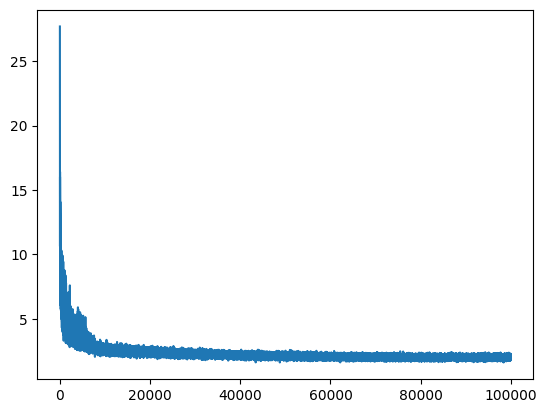

In [430]:
plt.plot(epochs,losses)

In [431]:
embeds = C[X_val]
embeds = embeds.view(embeds.shape[0],45)
h = torch.tanh(embeds @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,y_val)
print("Val Loss: ",loss)

Val Loss:  tensor(2.1032, grad_fn=<NllLossBackward0>)


In [432]:
embeds = C[X_train]
embeds = embeds.view(embeds.shape[0],45)
h = torch.tanh(embeds @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,y_train)
print("Training Loss: ",loss)

Training Loss:  tensor(2.0065, grad_fn=<NllLossBackward0>)


In [76]:
# As the training and validation loss around equal we are not overfitting and we are underfitting instead so this means that we should use a larger model
# as this model is not powerful enough
# lower batch size can lead to more noise

tensor([ 53449,  81964, 186548,  58230, 113948,  68904, 176596,  59478,  24312,
        112070, 207824,  95448,  33102, 206488, 222061, 226575,  46171,  69746,
         34752, 219314,   7628, 200782, 110374,  55227, 197718,  84128, 131386,
        167008, 219453, 145935,  31119, 146829,  74692, 107050,   4407,  63357,
         53374,  87173,  70708, 128655,  45855,  47580, 211383, 109303, 135681,
         48260,  67367,  48250, 170414,  76090, 146699,  83498,  93031, 179688,
        184634, 149344, 171388, 198089,  17762, 113641, 177292,  40089, 129203,
        178057])

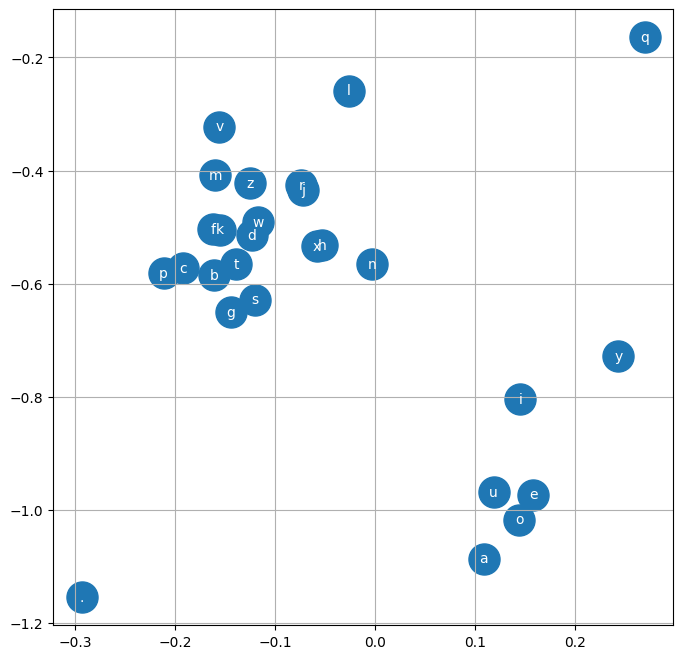

In [215]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=500)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [434]:
embeds = C[X_test]
embeds = embeds.view(embeds.shape[0],45)
h = torch.tanh(embeds @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,y_test)
print("Testing Loss: ",loss)

Testing Loss:  tensor(2.0963, grad_fn=<NllLossBackward0>)


In [451]:
for i in range(20):
  context = list('...')

  #
  s = ''
  while True:
    embeds = C[torch.tensor([stoi[c] for c in context])]
    embeds = embeds.view(1,45)
    h = torch.tanh(embeds @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits,dim=1)
    pred = torch.multinomial(probs,num_samples=1,generator=g)
    c = itos[pred.item()]
    s+=c
    if c == '.':
      break
    context = context[1:] + [c]
  print(s)

avrynel.
shirla.
sarius.
azalis.
bio.
zina.
abbie.
sida.
braileontanna.
kelyn.
zyan.
ler.
aliah.
dayra.
fbraydonyeyah.
ben.
sabell.
han.
kenza.
matterra.
